In [11]:
class simulation_class(object):
    def __init__(self, name, mar_env, corr):
        self.name = name
        self.pricing_date = mar_env.pricing_date
        self.initial_value = mar_env.get_constant('initial_value')
        self.volatility = mar_env.get_constant('volatility')
        self.final_date = mar_env.get_constant('final_date')
        self.currency = mar_env.get_constant('currency')
        self.frequency = mar_env.get_constant('frequency')
        self.paths = mar_env.get_constant('paths')
        self.discount_curve = mar_env.get_curve('discount_curve')
        try:
            self.time_grid = mar_env.get_list('time_grid')
        except:
            self.time_grid = None
        try:
            self.special_dates = mar_env.get_list('special_dates')
        except:
            self.special_dates = []
        self.instrument_values = None
        self.correlated = corr
        if corr is True:
            self.cholesky_matrix = mar_env.get_list('cholesky_matrix')
            self.rn_set = mar_env.get_list('rn_set')[self.name]
            self.random_numbers = mar_env.get_list('random_numbers')
    def generate_time_grid(self):
        start = self.pricing_date
        end = self.final_date
        time_grid = pd.date_range(start=start, end=end, freq=self.frequency).to_pydatetime()
        time_grid = list(time_grid)
        if start not in time_grid:
            time_grid.insert(0,start)
        if end not in time_grid:
            time_grid.append(end)
        if len(self.special_dates) > 0:
            time_grid.extend(self.special_dates)
            time_grid = list(set(time_grid))
            time_grid.sort()
        self.time_grid = np.array(time_grid)
    
    def get_instrument_values(self, fixed_seed=True):
        if self.instrument_values is None:
            self.generate_paths(fixed_seed=fixed_seed, day_count=365.)
        elif fixed_seed is False:
            self.generate_paths(fixed_seed=fixed_seed, day_count=365.)
        return self.instrument_values

In [21]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

In [13]:
def sn_random_numbers(shape, antithetic=True, moment_matching=True, fixed_seed=False):
    if fixed_seed:
        np.random.seed(1000)
    if antithetic:
        ran = np.random.standard_normal((shape[0], shape[1], shape[2]// 2))
        ran = np.concatenate((ran, -ran), axis=2)
    else:
        ran = np.random.standard_normal(shape)
    if moment_matching:
        ran = ran - np.mean(ran)
        ran = ran / np.std(ran)
    if shape[0] == 1:
        return ran[0]
    else:
        return ran

In [14]:
class geometric_brownian_motion(simulation_class):
   # Class to generate simulated paths based on the Black Scholes geometric Brownian motion model
    def __init__(self, name, mar_env, corr=False):
        super(geometric_brownian_motion, self).__init__(name, mar_env, corr)
    def update(self, initial_value=None, volatility=None, final_date=None):
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if final_date is not None:
            self.final_date = final_date
        self.instrument_values = None
    def generate_paths(self, fixed_seed=False, day_count=365.):
        if self.time_grid is None:
            self.generate_time_grid()
        M = len(self.time_grid)
        I = self.paths
        paths = np.zeros((M, I))
        paths[0] = self.initial_value
        if not self.correlated:
            rand = sn_random_numbers((1,M,I), fixed_seed=fixed_seed)
        else:
            rand = self.random_numbers
        short_rate = self.discount_curve.short_rate
        for t in range(1, len(self.time_grid)):
            if not self.correlated:
                ran = rand[t]
            else:
                ran = np.dot(self.cholesky_matrix, rand[:,t,:])
                ran = ran[self.rn_set]
            dt = (self.time_grid[t] - self.time_grid[t-1]).days / day_count
            paths[t] = paths[t - 1] * np.exp((short_rate - 0.5 * self.volatility ** 2) * dt + self.volatility * 
                                             np.sqrt(dt) * ran)
        self.instrument_values = paths

In [15]:
class constant_short_rate(object):
    def __init__(self, name, short_rate):
        self.name = name
        self.short_rate = short_rate
        if short_rate < 0:
            raise ValueError('Short rate negative')
    def get_discount_factors(self, date_list, dtobjects=True):
        if dtobjects is True:
            dlist = get_year_deltas(date_list)
        else:
            dlist = np.array(date_list)
        dflist = np.exp(self.short_rate * np.sort(-dlist))
        return np.array((date_list, dflist)).T
    def get_year_deltas(self, date_list, day_count=365):
        start = date_list[0]
        delta_list = [(date-start).days / day_count for date in date_list]
        return np.array(delta_list)

In [16]:
class market_environment(object):
    def __init__(self,name,pricing_date):
        self.name = name
        self.pricing_date = pricing_date
        self.constants = {}
        self.lists = {}
        self.curves = {}
    def add_constant(self, key, constant):
        self.constants[key] = constant
    def get_constant(self,key):
        return self.constants[key]
    def add_list(self,key,list_object):
        self.lists[key] = list_object
    def get_list(self,key):
        return self.lists[key]
    def add_curve(self,key, curve):
        self.curves[key] = curve
    def get_curve(self, key):
        return self.curves[key]
    def add_environment(self, env):
        self.constnats.update(env.constnats)
        self.lists.update(env.lists)
        self.curves.update(env.curves)

In [17]:
me_gbm = market_environment('me_gbm', dt.datetime(2020,1,1))

me_gbm.add_constant('initial_value', 36.)
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('final_date', dt.datetime(2020,12,31))
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('frequency', 'M')
me_gbm.add_constant('paths', 10000)

In [18]:
me_gbm.add_constant('initial_value', 36.) 
me_gbm.add_constant('volatility', 0.2) 
me_gbm.add_constant('final_date', dt.datetime(2020,12,31)) 
me_gbm.add_constant('currency', 'EUR') 
me_gbm.add_constant('frequency', 'M') 
me_gbm.add_constant('paths', 10000)


In [19]:
csr = constant_short_rate('csr', 0.06)
me_gbm.add_curve('discount_curve', csr)

In [20]:
gbm = geometric_brownian_motion('gbm', me_gbm)
gbm.generate_time_grid()
gbm.time_grid

array([datetime.datetime(2020, 1, 1, 0, 0),
       datetime.datetime(2020, 1, 31, 0, 0),
       datetime.datetime(2020, 2, 29, 0, 0),
       datetime.datetime(2020, 3, 31, 0, 0),
       datetime.datetime(2020, 4, 30, 0, 0),
       datetime.datetime(2020, 5, 31, 0, 0),
       datetime.datetime(2020, 6, 30, 0, 0),
       datetime.datetime(2020, 7, 31, 0, 0),
       datetime.datetime(2020, 8, 31, 0, 0),
       datetime.datetime(2020, 9, 30, 0, 0),
       datetime.datetime(2020, 10, 31, 0, 0),
       datetime.datetime(2020, 11, 30, 0, 0),
       datetime.datetime(2020, 12, 31, 0, 0)], dtype=object)

In [23]:
paths_1 = gbm.get_instrument_values()

In [24]:
gbm.update(volatility=0.5)
paths_2 = gbm.get_instrument_values()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


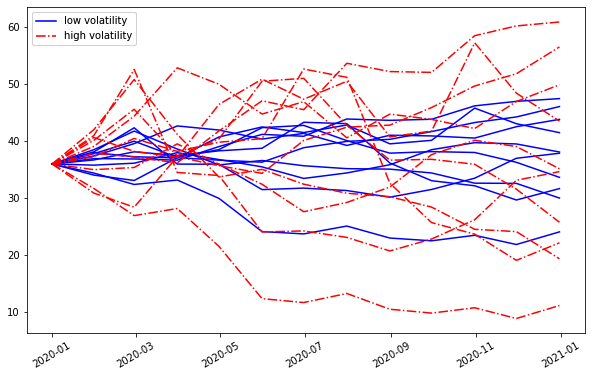

In [25]:
plt.figure(figsize=(10,6))
p1 = plt.plot(gbm.time_grid, paths_1[:,:10], 'b')
p2 = plt.plot(gbm.time_grid, paths_2[:, :10], 'r-.')
l1 = plt.legend([p1[0], p2[0]], ['low volatility', 'high volatility'],loc=2)
plt.gca().add_artist(l1)
plt.xticks(rotation=30);

In [ ]:
learn jump diffusion and revisit lecture on stochastics